In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import math

%matplotlib inline
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Naïve Bayes Classification

## Part A: Model Code


### 1. Implement a Multinomial_NB model class.

#### a) \_\_init\_\_

In [ ]:
class Multinomial_NB():
  pass

In [ ]:
class Multinomial_NB(Multinomial_NB):
  def __init__(self):
    pass

#### b) fit(self, X, Y)

no returns







In [ ]:
class Multinomial_NB(Multinomial_NB):
  def fit(self, X, Y, alpha=1.0):
    self.alpha = alpha
    # X and Y must have same no. of rows
    feature_count = np.shape(X)[1]
    row_count = np.shape(X)[0]
    classes = np.unique(Y)
    class_count = np.size(classes)

    pi = np.zeros(class_count) # probabilities of occurance of each class
    theta = np.zeros((feature_count, class_count)) # probablities of each feature occuring in each class

    for c in range(class_count):
      rows_in_c = np.count_nonzero(Y == classes[c])
      pi[c] = (self.alpha + rows_in_c) / ((self.alpha * class_count) + row_count)

    for j in range(feature_count):
      for c in range(class_count):
        feature_occurance_count = 0
        for r in range(row_count):
          if (Y[r] == classes[c]): # feature count belonging to class c
            feature_occurance_count += X[r][j]
        theta[j][c] = (self.alpha + feature_occurance_count) / ((self.alpha * feature_count) + feature_count)
        
    self.pi = pi
    self.theta = theta
    self.classes = classes
    self.class_count = class_count

#### c) predict(self, X)

**returns** 1D array of predictions

In [ ]:
class Multinomial_NB(Multinomial_NB):
  def predict(self, X):
    row_count = np.shape(X)[0]
    predictions = np.empty(row_count, dtype='U8')
    log_proba_predictions = self.predict_log_proba(X)
    # maximum probability of occuring in a class gives the prediction
    for row_index in range(row_count):
      proba = log_proba_predictions[row_index]
      max_proba = max(proba)
      max_proba_index = np.where(proba == max_proba)[0][0]
      predictions[row_index] = self.classes[max_proba_index]
    return predictions

#### d) predict_log_proba(self, X)

**returns** numpy array that contains log-probability of the samples (unnormalized log posteriors) for each class in the model.

In [ ]:
class Multinomial_NB(Multinomial_NB):
  def predict_log_proba(self, X):
    row_count = np.shape(X)[0]
    feature_count = np.shape(X)[1]
    probabilities = np.zeros((row_count, self.class_count))
    for c in range(self.class_count):
      pi = math.log(self.pi[c])
      for r in range(row_count):
        row = X[r]
        nonzero_indices = np.nonzero(row)[0]
        theta = 0
        for nonzero_index in nonzero_indices:
          t = self.theta[nonzero_index][c]
          if (t > 0):
            theta += math.log(t)
        probabilities[r][c] = pi + theta
    return probabilities

#### e) predict_proba(self, X)

**returns** a numpy array that contains probability of the samples
(unnormalized posterior) for each class in the model.

In [ ]:
class Multinomial_NB(Multinomial_NB):
  def predict_proba(self, X):
    row_count = np.shape(X)[0]
    feature_count = np.shape(X)[1]
    probabilities = np.zeros((row_count, self.class_count))
    for c in range(self.class_count):
      pi = self.pi[c]
      for r in range(row_count):
        row = X[r]
        nonzero_indices = np.nonzero(row)[0]
        theta = 0
        for nonzero_index in nonzero_indices:
          t = self.theta[nonzero_index][c]
          if (t > 0):
            theta += t
        probabilities[r][c] = pi + theta
    return probabilities

## Part B: Exploratory Data Analysis
### 2. Read CSV as pandas data frame.


In [ ]:
import urllib
from zipfile import ZipFile
downloader = urllib.request.URLopener()
downloader.retrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip", "smsspamcollection.zip")
downloader.close()
with ZipFile("smsspamcollection.zip", 'r') as zip:
  zip.extract('SMSSpamCollection')


In [ ]:
df = pd.read_csv('SMSSpamCollection', sep='\t', names=['class', 'text'])
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 3. Summarize data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.groupby('class').count()

,text
class,
ham,4825
spam,747


In [ ]:
df['length'] = df['text'].map(lambda text: len(text))

df.groupby('class').length.describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


__Observation note__: Spams generally tend to be longer with low deviation, meaning spams (at least in this dataset) have a predictable length. Hams generally tend to be shorter but has high deviation, meaning there are outliers in hams with respect to length of SMS.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff57a1fa550>,
      dtype=object)

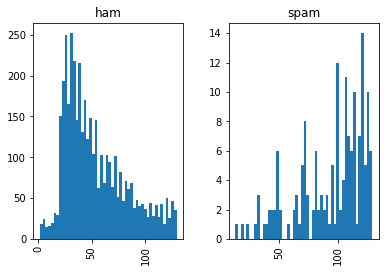

In [ ]:
df_subset = df[df.length < 130]
df_subset.hist(column='length', by='class', bins=50)

### 4. Generate a bar plot to display the class distribution.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


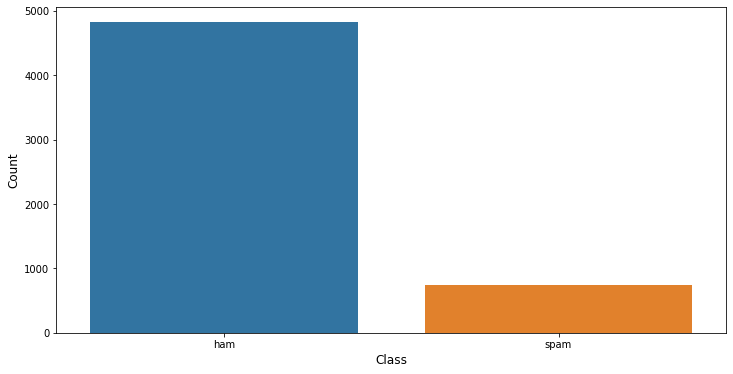

In [ ]:
label_counts = df['class'].value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

## Part C: Feature Extraction

### 5. Normalize

#### a) Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

#### Viewing change made in a random text

In [ ]:
random_row = 192
print(df['text'][random_row])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][random_row])

I'm sorry. I've joined the league of people that dont keep in touch. You mean a great deal to me. You have been a friend at all times even at great personal cost. Do have a great week.|

Lemmatized Email:

i 'm sorry . i 've joined the league of people that dont keep in touch . you mean a great deal to me . you have been a friend at all time even at great personal cost . do have a great week.|


#### b) Stemming

In [ ]:
stemmer = PorterStemmer()

df['text_stemmed'] = df['text'].map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text.lower())))

In [ ]:
print(df['text'][random_row])
print("\nStemmed Email:\n")
print(df['text_stemmed'][random_row])

I'm sorry. I've joined the league of people that dont keep in touch. You mean a great deal to me. You have been a friend at all times even at great personal cost. Do have a great week.|

Stemmed Email:

i 'm sorri . i 've join the leagu of peopl that dont keep in touch . you mean a great deal to me . you have been a friend at all time even at great person cost . do have a great week.|


### 6. Generate word clouds for both the spam and ham emails.

#### Word cloud of Spam SMS

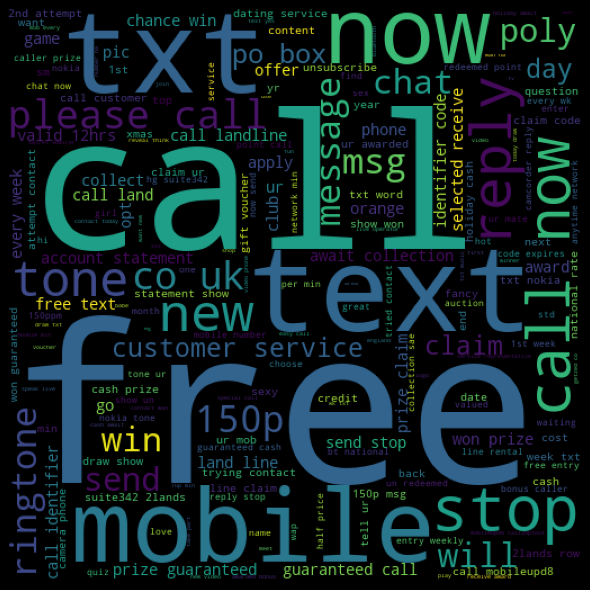

In [ ]:
spam_words = ''.join(list(df[df['class']=='spam']['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### Word cloud of Ham SMS

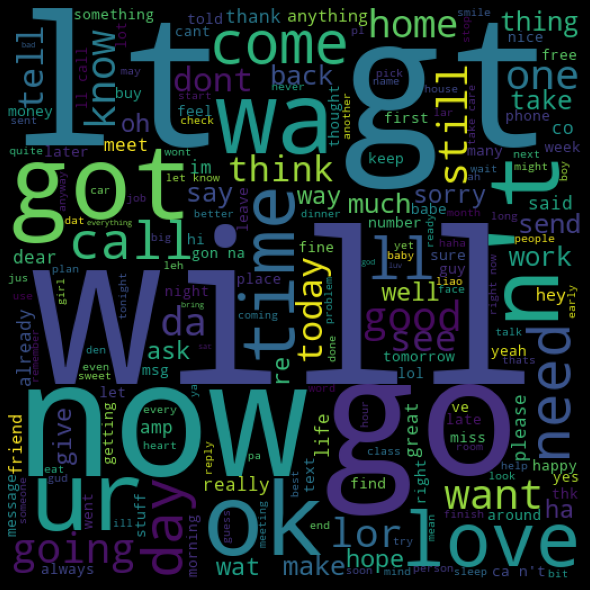

In [ ]:
spam_words = ''.join(list(df[df['class']=='ham']['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### 7. Remove stop words and convert the text into numerical feature vectors.

In [ ]:
X_lemmatized = df['text_lemmatized']

print(X_lemmatized.shape)

(5572,)


#### Removing stop words and counting words

In [ ]:
count_vect = CountVectorizer(lowercase=True, stop_words='english')

X_counts = count_vect.fit_transform(X_lemmatized)
print(X_counts.shape) # no. of rows = no. of SMS, no. of columns = no. of features (word)
print(type(X_counts))

# understanding CountVectorizer
print(X_counts[0]) # X_counts stores the count of each feature in a SMS, displaying counts for first SMS
print(count_vect.get_feature_names()[2193]) # The name of the feature can be viewed like this
print(X_lemmatized[0]) # displaying SMS to confirm that the words exists

(5572, 7963)
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 4045)	1
  (0, 5468)	1
  (0, 2193)	1
  (0, 1260)	1
  (0, 1669)	1
  (0, 3388)	1
  (0, 7811)	1
  (0, 4164)	1
  (0, 1667)	1
  (0, 1938)	1
  (0, 3351)	1
  (0, 1050)	1
  (0, 7627)	1
crazy
go until jurong point , crazy.. available only in bugis n great world la e buffet ... cine there got amore wat ...


#### Weighing features with respect to their frequency

In [ ]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

print(X_tfidf[0]) # X_tfidf stores the weight of each feature in a SMS, displaying weights for first SMS

(5572, 7963)
  (0, 7811)	0.23761459638681015
  (0, 7627)	0.19804685590869756
  (0, 5468)	0.24202815374163827
  (0, 4164)	0.2994435140823586
  (0, 4045)	0.3544532217582374
  (0, 3388)	0.19580015499495476
  (0, 3351)	0.16431521096738227
  (0, 2193)	0.2744996208031445
  (0, 1938)	0.2994435140823586
  (0, 1669)	0.2994435140823586
  (0, 1667)	0.3383639136752265
  (0, 1260)	0.2651194502247496
  (0, 1050)	0.3544532217582374


### 8. Create X and y.

In [ ]:
X = pd.DataFrame.sparse.from_spmatrix(X_counts)
X['class'] = df['class']
y = df['class']

### 9. Shuffle the rows of your data.

In [ ]:
X_random = X.sample(frac=1)
X = X_random.drop(columns=['class'])
y = X_random['class']
print(X)
print(y)

      0     1     2     3     4     5     ...  7957  7958  7959  7960  7961  7962
151      0     0     0     0     0     0  ...     0     0     0     0     0     0
1532     0     0     0     0     0     0  ...     0     0     0     0     0     0
4484     0     0     0     0     0     0  ...     0     0     0     0     0     0
5374     0     0     0     0     0     0  ...     0     0     0     0     0     0
4183     0     1     0     0     0     0  ...     0     0     0     0     0     0
...    ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
4052     0     0     0     0     0     0  ...     0     0     0     0     0     0
1558     0     0     0     0     0     0  ...     0     0     0     0     0     0
2770     0     0     0     0     0     0  ...     0     0     0     0     0     0
3404     0     0     0     0     0     0  ...     0     0     0     0     0     0
4929     0     0     0     0     0     0  ...     0     0     0     0     0     0

[5572 rows x 79

### 10. Partition the data

In [ ]:
def partition(f_matrix, t_vector, T):
  if (len(f_matrix) != len(t_vector)):
      raise Exception('Your feature matrix is not of the same length as your testing vector.')
  split_value = int(len(f_matrix)*T)
  test_matrix = f_matrix[:split_value]
  test_vector = t_vector[:split_value]
  train_matrix = f_matrix[split_value:]
  train_vector = t_vector[split_value:]
  return train_matrix, train_vector, test_matrix, test_vector

In [ ]:
X_train, y_train, X_test, y_test =  partition(X.to_numpy(), y.to_numpy(), .2)

In [ ]:
print(X_test)
print(y_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


### Testing Model

This section is for testing purposes only and will be removed in final assignment submission.

In [ ]:
# test model

nb = Multinomial_NB()

In [ ]:
nb.fit(X_train, y_train)

In [ ]:
print(nb.pi)
print(nb.theta)
print(nb.theta.shape)
print(nb.classes)

[0.86412556 0.13587444]
[[6.27904056e-05 5.02323245e-04]
 [6.27904056e-05 1.50696974e-03]
 [6.27904056e-05 6.27904056e-05]
 ...
 [1.25580811e-04 6.27904056e-05]
 [6.27904056e-05 6.27904056e-05]
 [6.27904056e-05 6.27904056e-05]]
(7963, 2)
['ham' 'spam']


In [ ]:
predictions = nb.predict(X_train)

In [ ]:
def test_accuracy(actual, prediction):
  cm = pd.crosstab(actual, prediction, rownames=['actual'], colnames=['predictions'])
  print(cm)
  # returns TN, FP, FN, TP
  TN = cm.iloc[0,0]
  FP = cm.iloc[0,1]
  FN = cm.iloc[1,0]
  TP = cm.iloc[1,1]
  return (TP + TN) / (TP + TN + FP + FN)

In [ ]:
print(y_train)
print(predictions)

['spam' 'ham' 'spam' ... 'spam' 'ham' 'ham']
['spam' 'ham' 'ham' ... 'spam' 'ham' 'ham']


In [ ]:
test_accuracy(y_train, predictions)

predictions   ham  spam
actual                 
ham          3852     1
spam           60   545


0.9863167339614177

In [ ]:
test_pred = nb.predict(X_test)
test_accuracy(y_test, test_pred)

0.9775583482944344

## Part D: Model Evaluation

11. Model selection via Hyper-parameter tuning
12. Generate ROC Curve and compute the AUC

In [ ]:
def confusion_matrix_binary(actual, prediction):
    return pd.crosstab(actual, prediction, rownames=['actual'], colnames=['predictions'])
def confusion_matrix_binary_values(cm):
    # returns TN, FP, FN, TP
    return cm.iloc[0,0], cm.iloc[0,1], cm.iloc[1,0], cm.iloc[1,1]

In [ ]:
def mulitlabel_confusion_matrix(actual, predictions):

  # So to get an accurate count of the true possitives of each class
  # take for example 3 classes
  # this will produce a 1d array of 3 elements
  arrbool = actual == predictions
  tp = actual[arrbool]
  # bin count counts up each class
  tp = np.bincount(tp)

  # we then take a bin count of predictions and acutal values
  pred = np.bincount(predictions)
  true = np.bincount(actual)


  fp = pred - tp
  fn = true - tp
  tn = actual.shape[0] - tp - fp - fn

  # lastly we want to make a confusion matix for each class
  # This is by transposing and reashaping the array so that the format is
  # |====+====|
  # | tp | fp |
  # |----+----+
  # | tn | fn |
  # |====+====|
  #


  return np.array([tp.tolist(), fp.tolist(), 
                   tn.tolist(), fn.tolist()]).T.reshape(-1, 2, 2)


In [ ]:
# Functions made by using the listed formulas from this source: 
# https://en.wikipedia.org/wiki/Confusion_matrix

# recall
def true_positive_rate(TP, FN):
    return (TP / (TP + FN))
# selectivity
def true_negative_rate(TN, FP):
    return (TN / (TN + FP))
# precision
def positive_predictive_value(TP, FP):
    return (TP / (TP + FP))
def negative_predictive_value(TN, FN):
    return (TN / (TN + FN))
# miss rate
def false_negative_rate(FN, TP):
    return (FN / (FN + TP))
# fall-out
def false_positive_rate(FP, TN):
    return (FP / (FP + TN))

def false_discovery_rate(FP, TP):
    return (FP / (FP + TP))

def false_omission_rate(FN, TN):
    return (FN / (FN + TN))

def prevalence_threshold(TPR, TNR):
    return (np.sqrt(TPR(-TNR + 1) + TNR - 1)) / (TPR + TNR - 1)

def threat_score(TP, FN, FP):
    return TP / (TP + FN + FP)

def accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

# added to complete question 3
def generalization_error(ACC):
    return abs(ACC - 1)

def balanced_accuracy(TPR, TNR):
    return (TPR + TNR) / 2

def f1_score(PPV, TPR):
    return 2 * ((PPV * TPR) / (PPV + TPR))

def matthews_correlation_coefficient(TP, TN, FP, FN):
    return (TP * TN - FP * FN) / np.sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))

def fowlkes_mallows_index(PPV, TPR):
    return np.sqrt(PPV * TPR)

def bookmaker_informedness(TPR, TNR):
    return TPR + TNR - 1

def markedness(PPV, NPV):
    return PPV + NPV -1

In [ ]:
def multilabel_acc(cm):
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  for c in cm:
    tp += c[0][0]
    fp += c[0][1]
    tn += c[1][0]
    fn += c[1][1]
  ACC = accuracy(tp, tn, fp, fn)
  return ACC

In [ ]:
def kFold(data, 
          labels, 
          model, 
          model_args, 
          error_function,
          folds=5):
  
    data_size = data.shape[0] 
    s_partition_size = 1 / folds
    segment_indexes = [ [int(np.floor(s_partition_size * i * data_size)), 
                         int(np.floor(s_partition_size * (i + 1) * data_size) - 1)] 
                       for i in range(folds) ]
    ret = []
    for p in range(folds):
        # takes the current segment as training data
        test_data = data[segment_indexes[p][0]:segment_indexes[p][1]]
        test_labels = labels[segment_indexes[p][0]:segment_indexes[p][1]]
        
        # creates copies of the data and labels with the testing data segment 
        # removed.
        train_data =\
         np.delete(data, 
                   np.s_[segment_indexes[p][0]:segment_indexes[p][1]], 0)
        train_labels =\
         np.delete(labels, 
                   np.s_[segment_indexes[p][0]:segment_indexes[p][1]], 0)
        
        model.fit(train_data, train_labels, **model_args)
        predictions = model.predict(X=test_data)

        cm = confusion_matrix_binary(test_labels, predictions)
        TN, FP, FN, TP = confusion_matrix_binary_values(cm)

        FPR = false_positive_rate(FP, TN)
        TPR = true_positive_rate(TP, FN)
        PPV = positive_predictive_value(TP, FP)

        F1 = f1_score(PPV, TPR)

        ret.append([TN, FP, FN, TP, FPR, TPR, F1])

    return ret

In [ ]:
# well in order to verify the 
def roc_curve(tpr_list, fpr_list):
    tpr_list = np.asarray(tpr_list)
    fpr_list = np.asarray(fpr_list)
    tpr_list = np.insert(tpr_list, 0, 0)
    fpr_list = np.insert(fpr_list, 0, 0)
    tpr_list = np.append(tpr_list, 1)
    fpr_list = np.append(fpr_list, 1)

    if (len(tpr_list) != len(fpr_list)):
        raise Exception('The list of TPR values is not the same size as the list of FPR values.')
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_list, tpr_list, 'b')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return plt

In [ ]:
def compute_auc(tpr_list, fpr_list):
    tpr_list = np.asarray(tpr_list)
    fpr_list = np.asarray(fpr_list)
    tpr_list = np.insert(tpr_list, 0, 0)
    fpr_list = np.insert(fpr_list, 0, 0)
    tpr_list = np.append(tpr_list, 1)
    fpr_list = np.append(fpr_list, 1)
    return np.trapz(tpr_list, fpr_list)

Alpha: 0.0001
AUC Score: 0.947534418818121


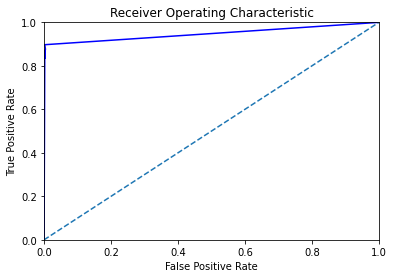



Alpha: 0.001
AUC Score: 0.9475030914862804


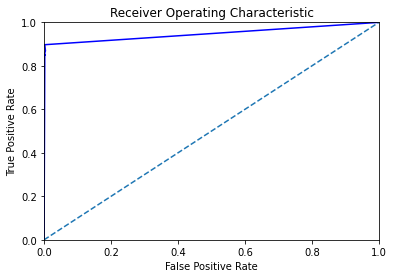



Alpha: 0.01
AUC Score: 0.9441151098019545


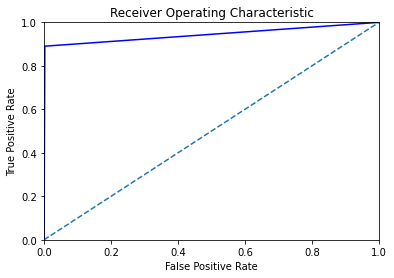



Alpha: 0.1
AUC Score: 0.9412087829777857


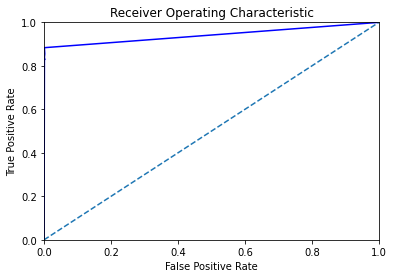



Alpha: 0.5
AUC Score: 0.9378196633441579


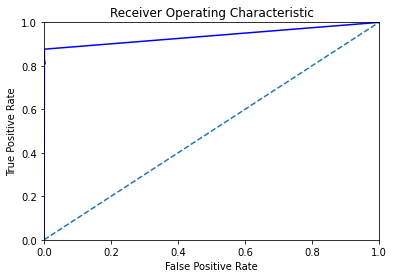



Alpha: 1.0
AUC Score: 0.9349299767737564


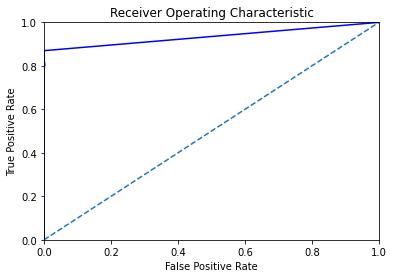



Alpha: 1.5
AUC Score: 0.9212275614121738


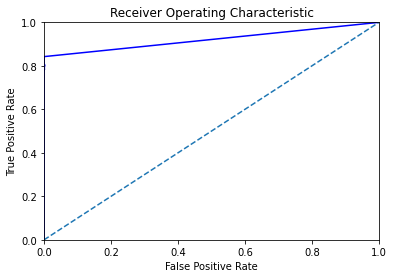



Alpha: 2.0
AUC Score: 0.9177887141639226


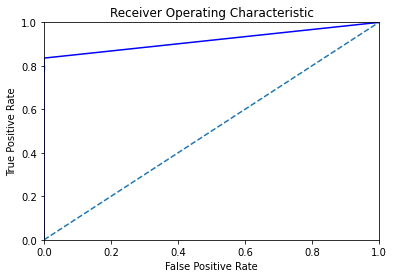

In [ ]:
results = []
for alpha in [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]:
  ret = kFold(X.to_numpy(), y.to_numpy(), Multinomial_NB(), {'alpha': alpha}, test_accuracy)
  tpr_list = []
  fpr_list = []
  for fold in ret:
    tpr_list.append(fold[5])
    fpr_list.append(fold[4])
  print('Alpha: {}'.format(alpha))
  print('AUC Score: {}'.format(compute_auc(tpr_list, fpr_list)))
  roc_curve(tpr_list, fpr_list)
  plt.show()
  print()
  print()
  results.append(ret)




In [ ]:
# testing if using stemming will improve accuracy

X_stemmed = df['text_stemmed']
X_counts_stem = count_vect.fit_transform(X_stemmed)

X_stem = pd.DataFrame.sparse.from_spmatrix(X_counts_stem)
X_stem['class'] = df['class']
y_stem = df['class']

X_random_stem = X_stem.sample(frac=1)
X_stem = X_random_stem.drop(columns=['class'])
y_stem = X_random_stem['class']

X_train_stem, y_train_stem, X_test_stem, y_test_stem =  partition(X_stem.to_numpy(), y_stem.to_numpy(), .2)

nb.fit(X_train_stem, y_train_stem)

predictions_stem = nb.predict(X_train_stem)

print("Train accuracy: " + str(test_accuracy(y_train_stem, predictions_stem)))
test_pred_stem = nb.predict(X_test_stem)
print("Test accuracy: " + str(test_accuracy(y_test_stem, test_pred_stem)))

Train accuracy: 0.9831763122476447
Test accuracy: 0.9748653500897666


Alpha: 0.0001
AUC Score: 0.9249196117469684


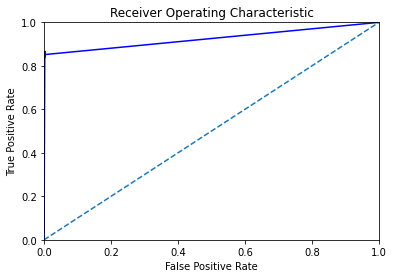



Alpha: 0.001
AUC Score: 0.9253489538003405


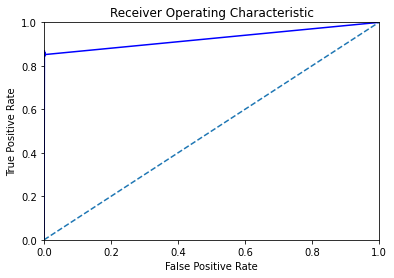



Alpha: 0.01
AUC Score: 0.9253281652419522


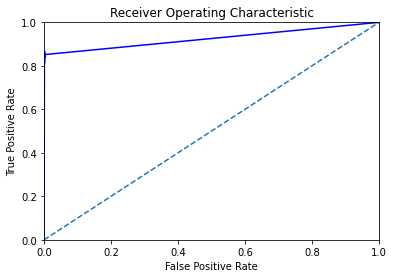



Alpha: 0.1
AUC Score: 0.9104936784947931


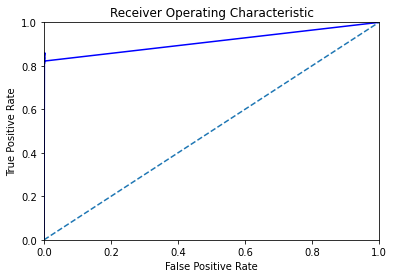



Alpha: 0.5
AUC Score: 0.9142821673241963


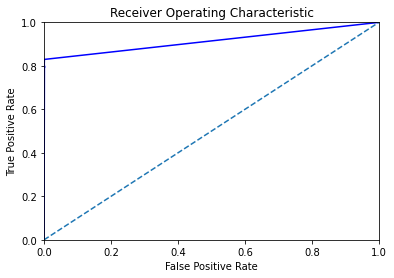



Alpha: 1.0
AUC Score: 0.8994699080920824


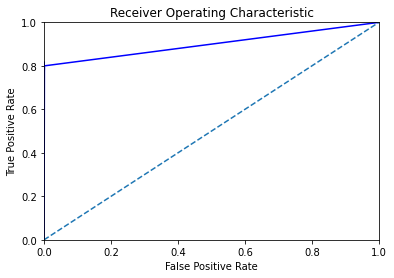



Alpha: 1.5
AUC Score: 0.8924617192524495


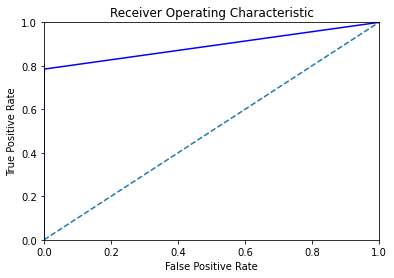



Alpha: 2.0
AUC Score: 0.8924457590890175


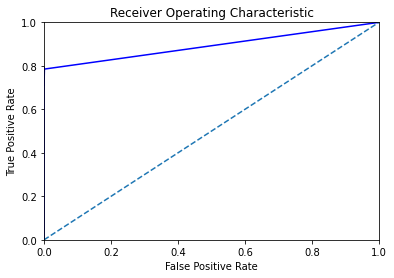

In [ ]:
results = []
for alpha in [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]:
  ret = kFold(X_stem.to_numpy(), y_stem.to_numpy(), Multinomial_NB(), {'alpha': alpha}, test_accuracy)
  tpr_list = []
  fpr_list = []
  for fold in ret:
    tpr_list.append(fold[5])
    fpr_list.append(fold[4])
  print('Alpha: {}'.format(alpha))
  print('AUC Score: {}'.format(compute_auc(tpr_list, fpr_list)))
  roc_curve(tpr_list, fpr_list)
  plt.show()
  print()
  print()
  results.append(ret)

Observations:

1. Test accuracy in stemming less than lemmitization.

2. Getting better AUC score in stemming than lemmitization.

13.  Evaluate your model on the test data and report the following performance measures.
*   Precision
*   Recall
*   F1 Score
*   Confusion Matrix
*   Accuracy


Alpha: 2.0
AUC Score: 0.947534418818121


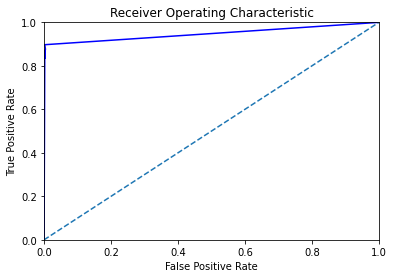

In [ ]:
results = []
ret = kFold(X.to_numpy(), y.to_numpy(), Multinomial_NB(), {'alpha': 0.0001}, test_accuracy)
tpr_list = []
fpr_list = []
for fold in ret:
  tpr_list.append(fold[5])
  fpr_list.append(fold[4])
print('Alpha: {}'.format(alpha))
print('AUC Score: {}'.format(compute_auc(tpr_list, fpr_list)))
roc_curve(tpr_list, fpr_list)
plt.show()
print()
print()
results.append(ret)

#TN, FP, FN, TP, FPR, TPR, F1

In [ ]:
precision = []
recall = []
f1 = []
acc = []

for fold in ret:
  tn = fold[0]
  fp = fold[1]
  fn = fold[2]
  tp = fold[3]

  print('Confusion Matrix at each fold: \n{}\n'.format(np.array([tp.tolist(), fp.tolist(), 
                   tn.tolist(), fn.tolist()]).T.reshape(-1, 2, 2)))

  precision.append(positive_predictive_value(TP=tp, FP=fp))
  recall.append(true_positive_rate(TP=tp, FN=fn))
  f1.append(fold[6])
  acc.append(accuracy(TP=tp, TN=tn, FP=fp, FN=fn))

 

print('Precision: {}\n'.format(np.mean(np.array(precision))))
print('Recall: {}\n'.format(np.mean(np.array(recall))))
print('F1 Score: {}\n'.format(np.mean(np.array(f1))))
print('Accuracy: {}\n'.format(np.mean(np.array(acc))))

Confusion Matrix at each fold: 
[[[129   2]
  [963  19]]]

Confusion Matrix at each fold: 
[[[127   3]
  [958  25]]]

Confusion Matrix at each fold: 
[[[139   2]
  [950  23]]]

Confusion Matrix at each fold: 
[[[121   4]
  [971  17]]]

Confusion Matrix at each fold: 
[[[131   2]
  [966  15]]]

Precision: 0.9800867820404949

Recall: 0.8678488993889243

F1 Score: 0.9204304686883897

Accuracy: 0.9798809886747287



# Logisitic Regression

## Part A: Model Code

### 15. one_hot_labels(Y)

Arguments:

> Y : 1D array containing data with “int” type that represents class indices/labels.

Returns:

> A matrix containing a one-hot vector for the Y of each instance.
> The number of rows is equal to the number of rows in Y. 
> The number of columns is equal to the number of unique class indices/labels in Y (i.e., the number of classes).

In [ ]:
def one_hot_labels(Y):
  unique, inv = np.unique(Y, return_inverse=True)
  one_hot_label_matrix = np.zeros((len(Y),len(unique)))
  for i in range(len(Y)):
    one_hot_label_matrix[i][inv[i]] = 1
  return one_hot_label_matrix

### 16. softmax(score)

In [ ]:
def softmax(score):
  exps = np.exp(score - np.max(score))
  return exps / np.sum(exps)

### 17. cross_entropy_loss(Y_one_hot, Y_proba)

In [ ]:
def cross_entropy_loss(Y_one_hot, Y_proba):
  return -np.sum(Y_one_hot.dot(np.log2(Y_proba)))

### 18. Softmax_Regression

Notes on the Softmax Regression
---

---

Dimensions
---
$X: N \text{ x } d$

$X^T: d \text{ x } N$

$\theta: d \text{ x } C = Y_{proba}$ 

$Y_{one-hot}: N \text{ x } C$

---
Equations
---

$$\vec{\theta}^{(0)} = \vec{0}$$

$$\sigma_{class} = \text{softmax}$$

$$ \mu = \sigma_{class} \Big(\vec{x}.\vec{\small\theta}^{(t)}\Big)$$

$$ \nabla = \vec{x}^T.\big[(\vec{\mu}-\vec{y}_{one-hot})\big]$$

Update Function Batch Gradient Descent

$$ \vec{\theta}^{(t+1)} = \vec{\theta}^{(t)}-\frac{\eta}{N}\nabla$$

Update Function Batch Gradient Descent L2 regularized

$$ \vec{\theta}^{(t+1)} = \vec{\theta}^{(t)}-\frac{\eta}{N}\Big[\nabla + \lambda\vec{\theta}^{(t)}\Big]$$

Update Function Batch Gradient Descent L1 regularized

$$ \vec{\theta}^{(t+1)} = \vec{\theta}^{(t)}-\frac{\eta}{N}\Big[\nabla + \lambda\text{sign}\big(\vec{\theta}^{(t)}\big)\Big]$$



In [ ]:
class Softmax_Regression():
  def __init__(self):
    pass

  def fit(self, 
          X, 
          Y, # not one-hot yet must transform
          alpha=0.01, 
          epochs=1000, 
          tol=None, 
          regularizer=None, 
          lambd=0.0, 
          early_stopping=False, 
          validation_fraction=0.1,
          **kwargs):
    
    self.alpha = alpha
    self.tol = tol
    self.lambd = lambd

    Y_hot = one_hot_labels(Y)
    self.theta = np.zeros((X.shape[1], Y_hot.shape[1]))

    if early_stopping:
      early_stop_acc = 0
      train_matrix, train_vector, test_matrix, test_vector = partition(X, Y, validation_fraction)

    for t in range(epochs):

      # found out that python 3.5 and numpy has @ for dot multiplication
      # my god it is so clean
      sigma = softmax(X @ self.theta)
      nabla = X.T @ (sigma - Y_hot)

      if regularizer == None:
        self.theta = self.theta - (alpha / len(X)) * (nabla)
      elif regularizer == 'l2':
        self.theta = self.theta - (alpha / len(X)) * (nabla + lambd * self.theta)
      elif regularizer == 'l1':
        self.theta = self.theta - (alpha / len(X)) * (nabla + lambd * np.sign(self.theta))
      
      if early_stopping:
        predictions = self.predict(test_matrix)
        cm = mulitlabel_confusion_matrix(test_vector, predictions)
        validate_acc = multilabel_acc(cm)
        if early_stop_acc < validate_acc:
          early_stop_acc = validate_acc
        else:
          break

    pass

  def predict(self, X):
    predictions = np.zeros((X.shape[0], 1))
    theta = self.theta.T
    for i in range(len(predictions)):
      values = np.zeros(len(theta))
      for j in range(len(theta)):
        values[j] = theta[j].T @ X[i]
      pick = np.where(values == np.amax(values))[0]
      predictions[i][0] = pick
    return np.ravel(predictions)



In [ ]:
class Stochastic_Softmax_Regression():
  def __init__(self):
    pass

  def fit(self, 
          X, 
          Y, # not one-hot yet must transform
          alpha=0.01, 
          epochs=1000, 
          tol=None, 
          regularizer=None, 
          lambd=0.0, 
          early_stopping=False, 
          validation_fraction=0.1,
          **kwargs):
    
    self.alpha = alpha
    self.tol = tol
    self.lambd = lambd

    Y_hot = one_hot_labels(Y)
    self.theta = np.zeros((X.shape[1], Y_hot.shape[1]))

    if early_stopping:
      early_stop_acc = 0
      train_matrix, train_vector, test_matrix, test_vector = partition(X, Y, validation_fraction)
      
    for i in range(len(X)):

      # found out that python 3.5 and numpy has @ for dot multiplication
      # my god it is so clean


      sigma = softmax(self.theta.T @ X[i])
      nabla = np.array([X[i].tolist()]).T @ np.array([(sigma - Y_hot[i]).tolist()]) 

      if regularizer == None:
        self.theta = self.theta - alpha * nabla
      elif regularizer == 'l2':
        self.theta = self.theta - alpha * (nabla + lambd * self.theta)
      elif regularizer == 'l1':
        self.theta = self.theta - alpha * (nabla + lambd * np.sign(self.theta))
      
      if early_stopping:
        predictions = self.predict(test_matrix)
        cm = mulitlabel_confusion_matrix(test_vector, predictions)
        validate_acc = multilabel_acc(cm)
        if early_stop_acc < validate_acc:
          early_stop_acc = validate_acc
        else:
          break

    pass

  def predict(self, X):
    predictions = np.zeros((X.shape[0], 1))
    theta = self.theta.T
    for i in range(len(predictions)):
      values = np.zeros(len(theta))
      for j in range(len(theta)):
        values[j] = theta[j].T @ X[i]
      pick = np.where(values == np.amax(values))[0]
      predictions[i][0] = pick
    return np.ravel(predictions)



## Part B: Exploratory Data Analysis

19. Read the Iris data using the sklearn.datasets.load_iris method.

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
iris_df["class"] = iris.target

20. Use the techniques from the second recitation to summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles.

In [ ]:
iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width,class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


21. Shuffle the rows of your data. You can use def = df.sample(frac=1) as an idiomatic way to shuffle the data in Pandas without losing column names. 

In [ ]:
iris_random_df = iris_df.sample(frac=1)

22. Generate pair plots using the seaborn package (see second recitation notebook). This will be used to identify and report the redundant features, if there is any.

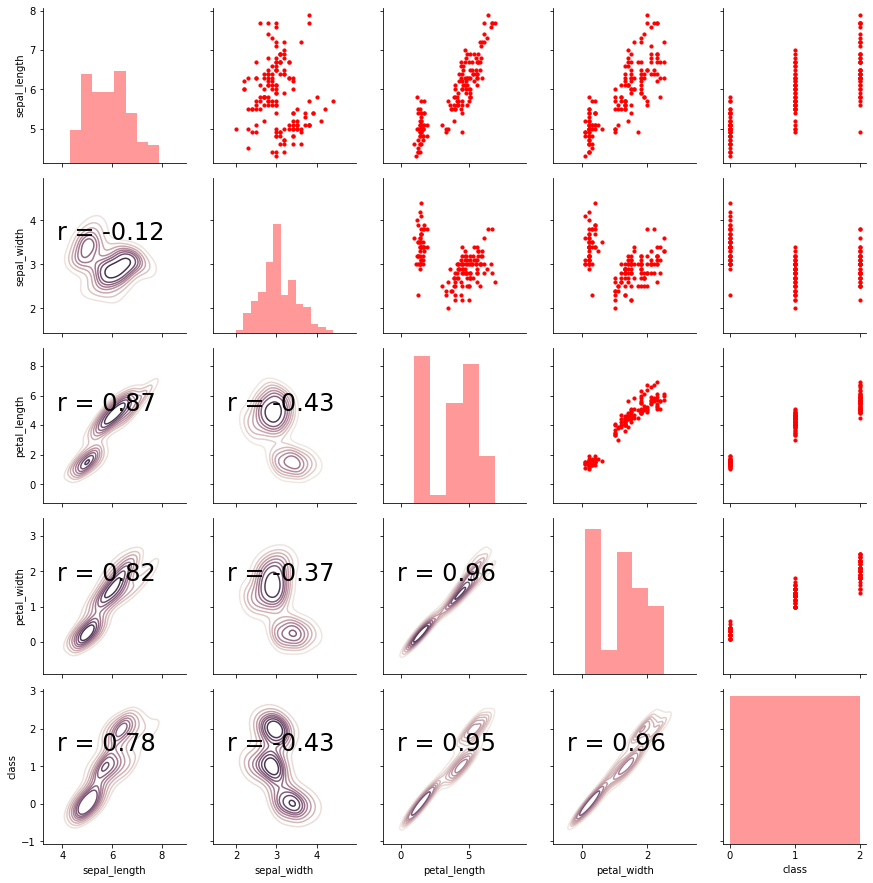

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), 
                xy=(.1, .6), 
                xycoords=ax.transAxes,
                size = 24)
    
# Set the color palette to use    
cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(iris_random_df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot, cmap = cmap)

There appears to be no redundant features with the iris dataset

23. Scale the features

In [ ]:
def mean_standardize(X: pd.Series):
  return pd.Series(
      [(X[i] - X.mean()) / (X.max() - X.min()) for i in range(X.count())])

In [ ]:
X = iris_random_df.drop(columns=['class'])
y = iris_random_df['class']

for i in X.columns:
  X[i] = mean_standardize(X[i])

24. Partition the data into train and test set. Use the “Partition” function from your previous assignment.

In [ ]:
train_matrix, train_vector, test_matrix, test_vector = partition(X.to_numpy(), y.to_numpy(), 0.2)

In [ ]:
def kFold(data, 
          labels, 
          model, 
          model_args, 
          error_function,
          folds=5):
  
    data_size = data.shape[0] 
    s_partition_size = 1 / folds
    segment_indexes = [ [int(np.floor(s_partition_size * i * data_size)), 
                         int(np.floor(s_partition_size * (i + 1) * data_size) - 1)] 
                       for i in range(folds) ]
    ret = []
    for p in range(folds):
        # takes the current segment as training data
        test_data = data[segment_indexes[p][0]:segment_indexes[p][1]]
        test_labels = labels[segment_indexes[p][0]:segment_indexes[p][1]]
        
        # creates copies of the data and labels with the testing data segment 
        # removed.
        train_data =\
         np.delete(data, 
                   np.s_[segment_indexes[p][0]:segment_indexes[p][1]], 0)
        train_labels =\
         np.delete(labels, 
                   np.s_[segment_indexes[p][0]:segment_indexes[p][1]], 0)
        
        model.fit(X=train_data, Y=train_labels, **model_args)
        predictions = model.predict(X=test_data)

        cm = mulitlabel_confusion_matrix(test_labels.astype(int), 
                                         predictions.astype(int))
        
        ACC = multilabel_acc(cm)

        ret.append(ACC)

    return ret

25. **Model selection via Hyper-parameter tuning**: Use the **kFold** function from previous assignment to evaluate the performance of your model over each combination of parameters from the following sets. You can increase the range of values, if needed and alsofor more experimentation.

>a. lambd= [0.1,0.01, 0.001, 0.0001]

>b. tol = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]

>c. learning_rate = [0.1, 0.01, 0.001]

>d. regularizer= [l1, l2]

>e. Store the returned dictionary for each and present it in the notebook.

>f. Determine the **best model** (model selection) based on the overall performance (lowest average error). For the error_function of the kFold function argument use accuracy.

In [ ]:
results_list = []
for lambd in [0.1, 0.01, 0.001, 0.0001]:
  for tol in [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]:
    for learning_rate in [0.1, 0.01, 0.001]:
      for regularizer in ['l1', 'l2']:
        kfolds = kFold(data=X.to_numpy(), 
                       labels=y.to_numpy(),
                       model=Softmax_Regression(),
                       model_args={
                            'lambd': lambd,
                            'tol': tol,
                            'learning_rate': learning_rate,
                            'regularizer': regularizer,
                        },
                       error_function=test_accuracy,
                       folds=2)
        results_list.append(kfolds)

In [ ]:
print([print(np.mean(i)) for i in results_list])

0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378378379
0.8378378378

Note: Given the size of the dataset being small, the k-fold function returns the same mean value for all different hyper-parameters. Picking any of the hyper-parameter values will work

26.Evaluate your model on the **test data** and report the accuracy and confusion matrix. 

In [ ]:
softmax_reg = Softmax_Regression()
softmax_reg.fit(X=train_matrix, 
                Y=train_vector,
                alpha=0.01,
                lambd=0.1,
                tol=0.001,
                regularizer='l1') 

predictions = softmax_reg.predict(test_matrix)

cm = mulitlabel_confusion_matrix(test_vector, predictions.astype(int))
print('Confusion Matrix: \n{}\n'.format(cm))

tp = 0
fp = 0
tn = 0
fn = 0
for c in cm:
  tp += c[0][0]
  fp += c[0][1]
  tn += c[1][0]
  fn += c[1][1]

acc = accuracy(tp, tn, fp, fn)
print('Accuracy: {}'.format(np.mean(acc)))

Confusion Matrix: 
[[[12  1]
  [17  0]]

 [[ 2  0]
  [20  8]]

 [[ 8  7]
  [15  0]]]

Accuracy: 0.8222222222222222


28. Evaluate your model (Stochastic Gradient Descent Logistic Algorithm) and report accuracy and confusion matrix

In [ ]:
stoch_results_list = []
for lambd in [0.1, 0.01, 0.001, 0.0001]:
  for tol in [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]:
    for learning_rate in [0.1, 0.01, 0.001]:
      for regularizer in ['l1', 'l2']:
        kfolds = kFold(data=X.to_numpy(), 
                       labels=y.to_numpy(),
                       model=Stochastic_Softmax_Regression(),
                       model_args={
                            'lambd': lambd,
                            'tol': tol,
                            'learning_rate': learning_rate,
                            'regularizer': regularizer,
                        },
                       error_function=test_accuracy,
                       folds=2)
        stoch_results_list.append(kfolds)

     

In [ ]:
softmax_reg = Stochastic_Softmax_Regression()

softmax_reg.fit(X=test_matrix, 
                Y=test_vector,
                alpha=0.01,
                lambd=0.1,
                tol=0.001,
                regularizer='l1') 

predictions = softmax_reg.predict(test_matrix)

cm = mulitlabel_confusion_matrix(test_vector, predictions.astype(int))
print('Confusion Matrix: \n{}\n'.format(cm))

tp = 0
fp = 0
tn = 0
fn = 0
for c in cm:
  tp += c[0][0]
  fp += c[0][1]
  tn += c[1][0]
  fn += c[1][1]

accuracy(tp, tn, fp, fn)
print('Accuracy: {}'.format(acc))

Confusion Matrix: 
[[[12  1]
  [17  0]]

 [[ 4  0]
  [20  6]]

 [[ 8  5]
  [17  0]]]

Accuracy: 0.8222222222222222
